# Analyse the SSNAP data

Descriptive analysis of the formatted SSNAP dataset.

Calculate the thrombolysis rates for subgroups of patients: different stroke severity, prior disability and discharge disability.

(This data analysis code was originally in notebook 230623_xgb_all_data_multiclass_shap.ipynb, along with fitting a model. Instead put in separate notebook in Oct 2023, the renamed in Nov 2023. Code previously read in the file '02_reformatted_data_ml_230612.csv'.)

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dataclasses import dataclass

import time

Report the time duration to run notebook

In [2]:
start_time = time.time()

In [14]:
surrogate_time_for_no_thrombolysis = 9999

## Set up paths and filenames

Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [3]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    data_read_path: str = '../data_processing/output'
    data_read_filename: str = '02_reformatted_data_ml_remove_mt.csv'
    notebook: str = '000_'
    model_text: str = 'ssnap_descriptive_stats'

paths = Paths()

## Import data

Import the formatted SSNAP dataset.

In [4]:
filename = os.path.join(paths.data_read_path, paths.data_read_filename)
data = pd.read_csv(filename)

In [5]:
data.shape

(168347, 56)

In [138]:
class_names = data['discharge_disability'].unique()
class_names = np.sort(class_names)
n_classes = len(class_names)
print(f'There are {n_classes} classes in the target feature')

There are 7 classes in the target feature


Get list of features

In [139]:
features = list(data)
print(f"There are {len(features)} features")

There are 57 features


Stroke teams

In [11]:
data["stroke_team"].nunique()

118

In [31]:
data.groupby(by=['stroke_team']).count()['age'].min()

358

In [32]:
data.groupby(by=['stroke_team']).count()['age'].max()

4559

# Define data types for features

In [12]:
feature_types = {
    'prior_disability': 'int',
    'stroke_severity': 'int',
    'stroke_team_id': 'category',
    'onset_to_thrombolysis': 'int',
    'age': 'float',
    'discharge_disability': 'category',
    'stroke_team': 'category'
}

### Calculate thrombolysis rates (per hospital, and per patient subgroups).

The receive thrombolysis feature is included in the dataset in the new feature onset_to_thrombolysis_time (if a patient receives thrombolysis the duration is stored, else store -100).

Create a temporary dataframe that contains the necessary data for this part of the analysis (a row per patient, five columns: Stroke team, Prior disability, discharge disability, stroke severity, receive thrombolysis)

In [15]:
# store necessary data in a temporary dataframe
columns = ["stroke_team", "prior_disability", "discharge_disability", 
           "stroke_severity"]

df_subdata = pd.DataFrame(data=data[columns], columns=columns)

mask = data['onset_to_thrombolysis_time'] != surrogate_time_for_no_thrombolysis
df_subdata["Thrombolysis"] = mask

Calculate thrombolysis rate per hospital

[Text(0.5, 0, 'Thrombolysis rate (%)'), Text(0, 0.5, 'Count of hospitals')]

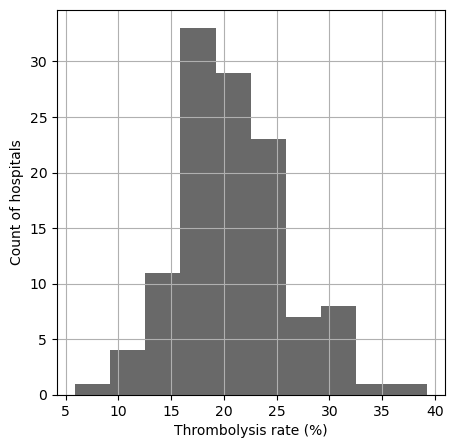

In [16]:
hosp_ivt_rate = (df_subdata.groupby(by=["stroke_team"]).mean()["Thrombolysis"])*100
ax = hosp_ivt_rate.hist(color='dimgrey', figsize=(5,5))
ax.set(xlabel="Thrombolysis rate (%)", ylabel="Count of hospitals")

In [19]:
hosp_ivt_rate.min()                

5.865921787709497

In [20]:
hosp_ivt_rate.max() 

39.24756154203437

Of those ?? patients that do not receive thrombolysis (and not thrombectomy), ??\% has mRS0, ??\% have mRS0-1, \% have mRS0-2, \% have mRS0-3, \% have mRS0-4, and \% have mRS0-5 at discharge. Of those ?? patients that receive thrombolysis (and not thrombectomy), ??\% has mRS0, \% have mRS0-1, \% have mRS0-2, \% have mRS0-3, \% have mRS0-4, and \% have mRS0-5.

In [42]:
mask_get_thrombolysis = data["onset_to_thrombolysis_time"] != surrogate_time_for_no_thrombolysis
print(mask_get_thrombolysis.sum())
data[mask_get_thrombolysis].groupby(by=["discharge_disability"]).count()["age"].cumsum()/(mask_get_thrombolysis.sum())

34831


discharge_disability
0.0    0.146105
1.0    0.352875
2.0    0.536017
3.0    0.692745
4.0    0.809825
5.0    0.861388
6.0    1.000000
Name: age, dtype: float64

In [43]:
mask_not_get_thrombolysis = data["onset_to_thrombolysis_time"] == surrogate_time_for_no_thrombolysis
print(mask_not_get_thrombolysis.sum())
data[mask_not_get_thrombolysis].groupby(by=["discharge_disability"]).count()["age"].cumsum()/(mask_not_get_thrombolysis.sum())

133516


discharge_disability
0.0    0.122555
1.0    0.334776
2.0    0.518095
3.0    0.691880
4.0    0.819939
5.0    0.883227
6.0    1.000000
Name: age, dtype: float64

The following sections will look at the proportion of patients that are given thrombolysis, grouped by a characteristic:

1. Prior disability
1. Discharge disability
1. Stroke severity

First, define function to be used in each of those sections

## Define functions use in the following sections

Define function to create dataframe

In [143]:
def create_groupby_dataframe(df, by_feature_name):
    """
    df (dataframe):
    feature_name (string): feature to group data on
    """

    df_result = pd.DataFrame()
    df_result["Total patients"] = (
                df.groupby(by=[by_feature_name]).count()["Thrombolysis"])
    df_result["Count get IVT"] = (
                df.groupby(by=[by_feature_name]).sum()["Thrombolysis"])
    df_result["Count not get IVT"] = (
                df_result["Total patients"] - df_result["Count get IVT"])
    df_result["Proportion get IVT"] = (
                df.groupby(by=[by_feature_name]).mean()["Thrombolysis"])
    
    return(df_result)

Define function to create piechart

In [144]:
def create_piechart(df, labels, colors):
    """
    df (dataframe)
    mylabel (list)
    colors (list)
    """
    # initialise list to contain counts of patients
    list_results = []
    list_results.extend(df["Count get IVT"])
    list_results.extend(df["Count not get IVT"])

    myexplode = [0.01] * len(labels)

    # plot the piechart
    plt.pie(list_results, labels=labels, explode=myexplode, 
            rotatelabels = 270, textprops={'fontsize': 8}, colors=colors)

    # add a circle at the center to transform it in a donut chart
    my_circle=plt.Circle( (0,0), 0.5, color='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)

    plt.show()

    return()

Define function to create bar plots of proportion of patients in each group to receive thrombolysis

In [145]:
def create_plots_proportion_get_thrombolysis(df, text):
    
    fig = plt.figure(figsize=(15,5))

    ax1 = fig.add_subplot(1,2,1)

    ax2 = ax1.twinx()
    ax1.bar(df.index, df["Proportion get IVT"], color="grey")
    ax2.plot(df.index, df["Total patients"], color="green")

    ax1.set_xlabel(f'{text}')
    ax1.set_ylabel('Proportion get IVT')
    ax2.set_ylabel(f'Total patients with this {text}', color='green')
    ax2.tick_params(axis='y', colors='green')
    ax3 = fig.add_subplot(1,2,2)

    df[["Count get IVT","Count not get IVT"]].plot(
                                kind='bar', stacked=True, 
                                ylabel="Number of patients",
                                xlabel=f'{text}', ax=ax3, )
    # resize x tick labels
    ax3.tick_params(axis='x', labelsize=8)

    # control white space
    plt.subplots_adjust(wspace=0.5)

    plt.show()

    return()

Define function to create stacked barplot of proportion of patients in each group, by hospital

In [146]:
def create_stacked_barplot_by_hospital(df, text):
    ax = df.plot(kind='bar', stacked=True, figsize=(20,8), ylabel="Proportion of patients", xlabel="Stroke team")
    ax.tick_params(axis='x', labelsize=9)
    ax.legend(loc='upper right', bbox_to_anchor=(1.22, 1), title=f"Receive thrombolysis, {text}")
    ax.set_ylim([0,1])
    plt.show()

    return()

### Feature 1. Group patients by prior disability

In [147]:
feature_name = "prior_disability"

In [148]:
df_prior_disability_results = create_groupby_dataframe(df_subdata, 
                                                       feature_name)
df_prior_disability_results

,Total patients,Count get IVT,Count not get IVT,Proportion get IVT
prior_disability,,,,
0,87928,22092,65836,0.251251
1,27657,5279,22378,0.190874
2,17769,2835,14934,0.159548
3,20803,3138,17665,0.150844
4,11034,1251,9783,0.113377
5,3156,236,2920,0.074778


Display these proportions (the treatment that patients get in each prior disability category) as a piechart

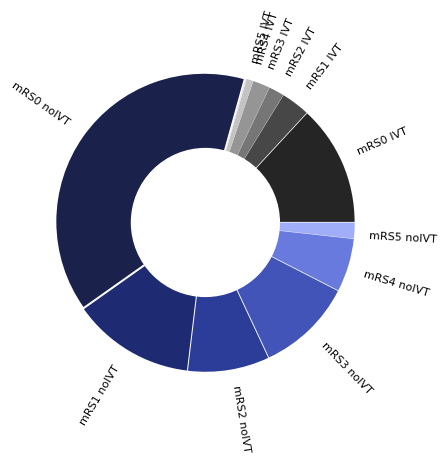

()

In [149]:
list_labels = ["mRS0 IVT", "mRS1 IVT", "mRS2 IVT", "mRS3 IVT", "mRS4 IVT", 
        "mRS5 IVT", "mRS0 noIVT", "mRS1 noIVT", "mRS2 noIVT", "mRS3 noIVT", 
        "mRS4 noIVT", "mRS5 noIVT"]

# Generate html colour codes https://htmlcolorcodes.com/
list_colors = ['#252525','#474747','#767676','#969595','#C4C3C3','#E5E4E4',
        '#1A214B','#1E2A72','#2C3C99','#4354B8','#697ADE', '#A0ADF9']

create_piechart(df_prior_disability_results, list_labels, list_colors)

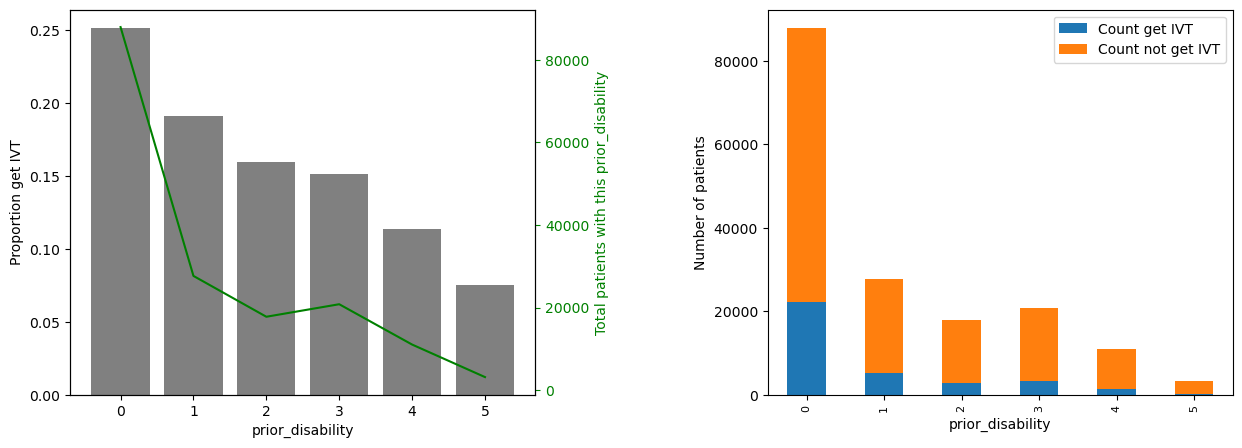

()

In [150]:
create_plots_proportion_get_thrombolysis(df_prior_disability_results, feature_name)

Show these values per hospital (as a stacked barchart): Proportion of each prior disability category to get thrombolysis

Display as stacked barplot
https://stackoverflow.com/questions/34917727/stacked-bar-plot-by-grouped-data-with-pandas

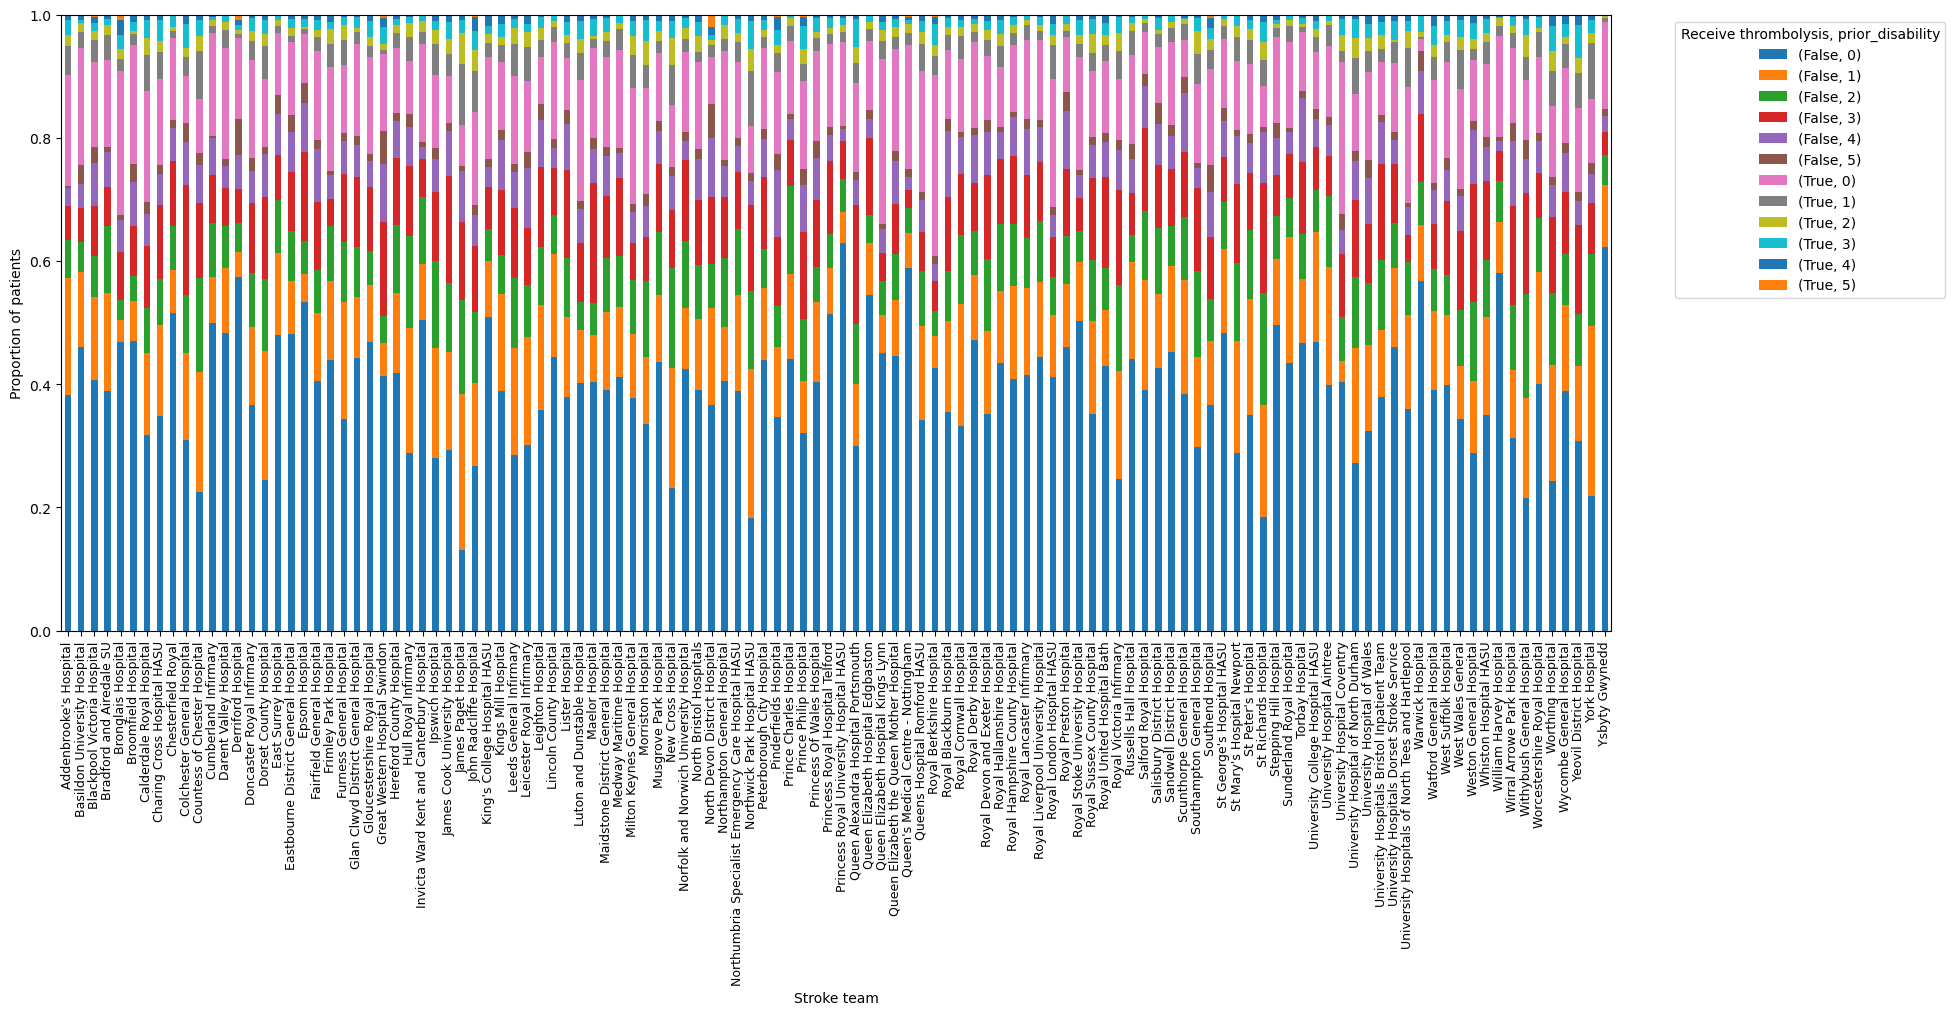

()

In [151]:
# Groupby hospital, count the number of patients with each prior disability and 
# whether receive thrombolysis
cols_by = ["stroke_team", feature_name, "Thrombolysis"]
df_subdata_groupby = df_subdata.groupby(by=cols_by).size().unstack().unstack()

# Represent values as proportions (per hospital)
df_to_plot = df_subdata_groupby.div(df_subdata_groupby.sum(axis=1), axis=0)

# Show in stacked barplot
create_stacked_barplot_by_hospital(df_to_plot, feature_name)

### Feature 2. Group patients by discharge disability

In [152]:
feature_name = "discharge_disability"

In [153]:
df_discharge_disability_results = create_groupby_dataframe(df_subdata, 
                                                           feature_name)
df_discharge_disability_results

,Total patients,Count get IVT,Count not get IVT,Proportion get IVT
discharge_disability,,,,
0.0,21452,5089,16363,0.237227
1.0,35537,7202,28335,0.202662
2.0,30855,6379,24476,0.206741
3.0,28662,5459,23203,0.190461
4.0,21176,4078,17098,0.192577
5.0,10246,1796,8450,0.175288
6.0,20419,4828,15591,0.236446


Display as piechart

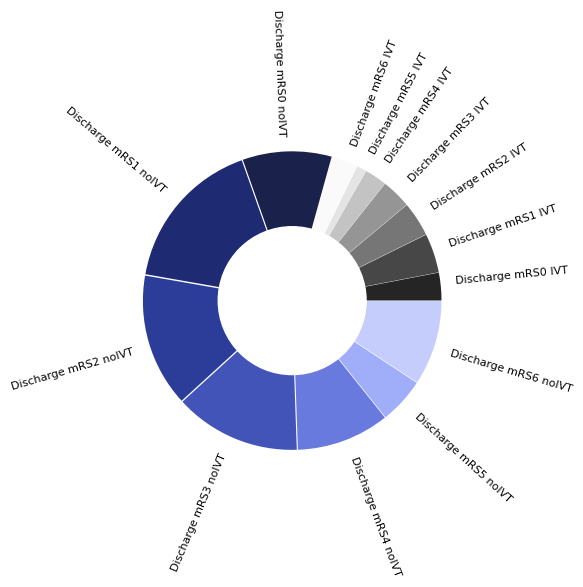

()

In [154]:
list_labels = ["Discharge mRS0 IVT", "Discharge mRS1 IVT", "Discharge mRS2 IVT", 
           "Discharge mRS3 IVT", "Discharge mRS4 IVT", "Discharge mRS5 IVT", 
           "Discharge mRS6 IVT", 
           "Discharge mRS0 noIVT", "Discharge mRS1 noIVT", 
           "Discharge mRS2 noIVT", "Discharge mRS3 noIVT", 
           "Discharge mRS4 noIVT", "Discharge mRS5 noIVT", 
           "Discharge mRS6 noIVT"]

# Generate html colour codes https://htmlcolorcodes.com/
list_colors = ['#252525','#474747','#767676','#969595','#C4C3C3','#E5E4E4', 
          '#FAFAFA', '#1A214B','#1E2A72','#2C3C99','#4354B8','#697ADE', 
          '#A0ADF9','#C5CDFC']

create_piechart(df_discharge_disability_results, list_labels, list_colors)

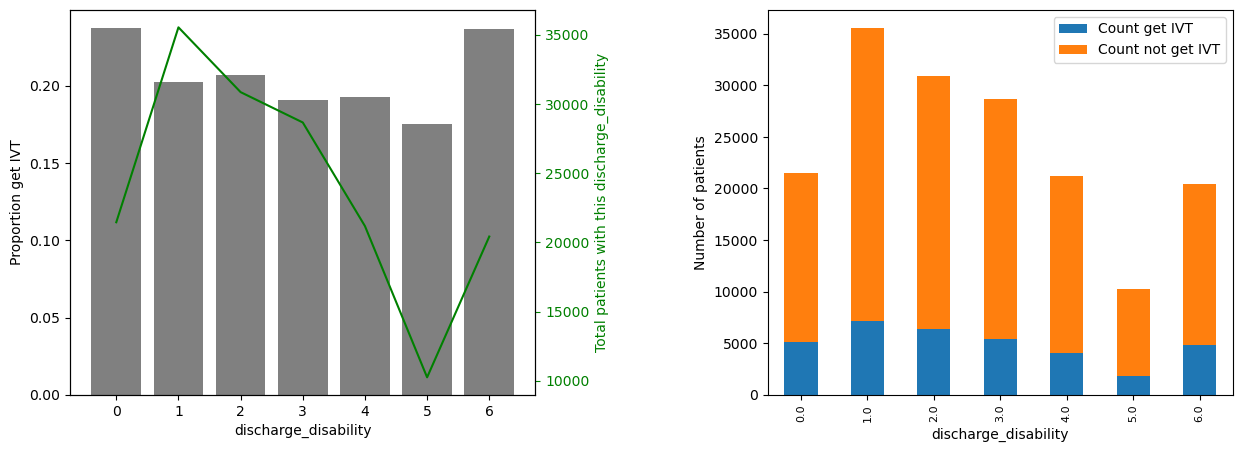

()

In [155]:
create_plots_proportion_get_thrombolysis(df_discharge_disability_results, feature_name)

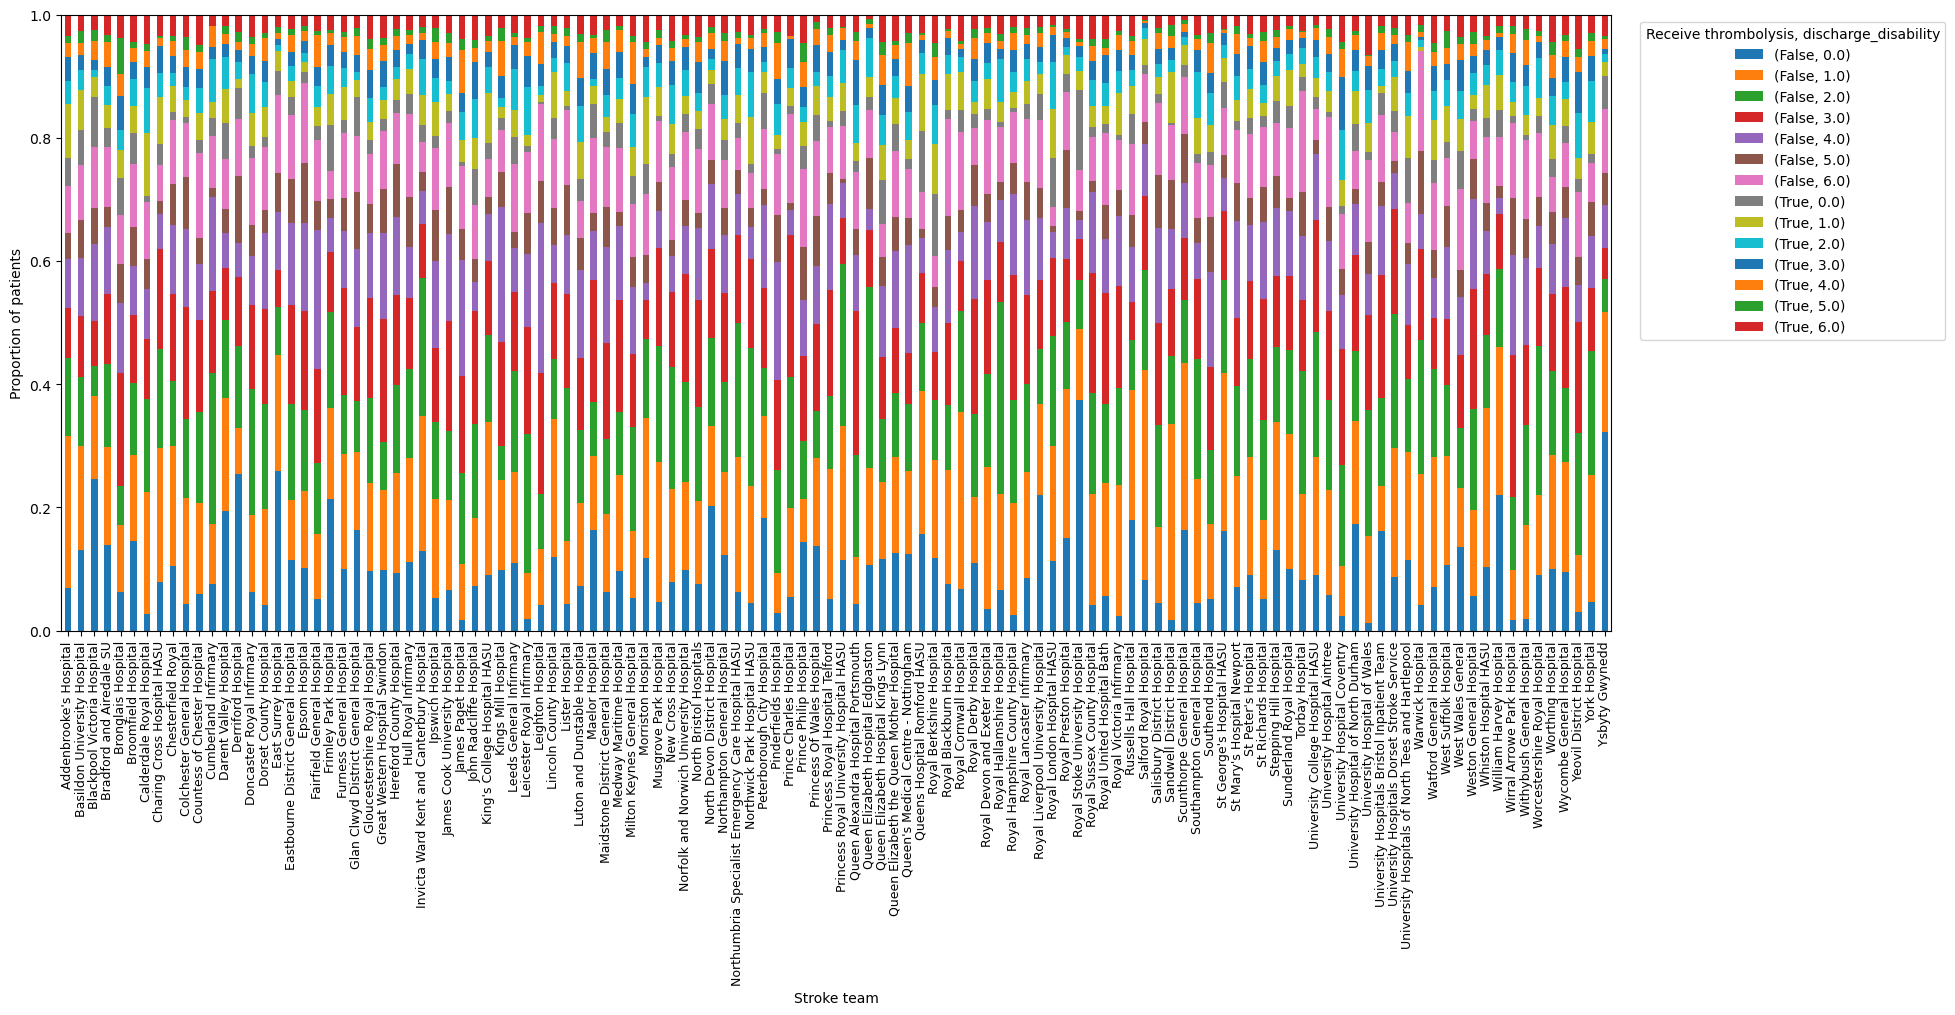

()

In [156]:
# Groupby hospital, count the number of patients with each prior disability and 
# whether receive thrombolysis
cols_by = ["stroke_team", feature_name, "Thrombolysis"]
df_subdata_groupby = df_subdata.groupby(by=cols_by).size().unstack().unstack()

# Represent values as proportions (per hospital)
df_to_plot = df_subdata_groupby.div(df_subdata_groupby.sum(axis=1), axis=0)

# Show in stacked barplot
create_stacked_barplot_by_hospital(df_to_plot, feature_name)

### Feature 3. Group patients by stroke severity

In [157]:
feature_name = "stroke_severity"

In [158]:
df_stroke_severity_results = create_groupby_dataframe(df_subdata, 
                                                      feature_name)
df_stroke_severity_results

,Total patients,Count get IVT,Count not get IVT,Proportion get IVT
stroke_severity,,,,
0,11726,159,11567,0.013560
1,15354,378,14976,0.024619
2,20820,1131,19689,0.054323
3,18594,1838,16756,0.098849
4,15613,2802,12811,0.179466
5,12373,3104,9269,0.250869
6,10053,2968,7085,0.295235
7,7665,2422,5243,0.315982
8,6240,2122,4118,0.340064


Proportion of each patient group get IVT

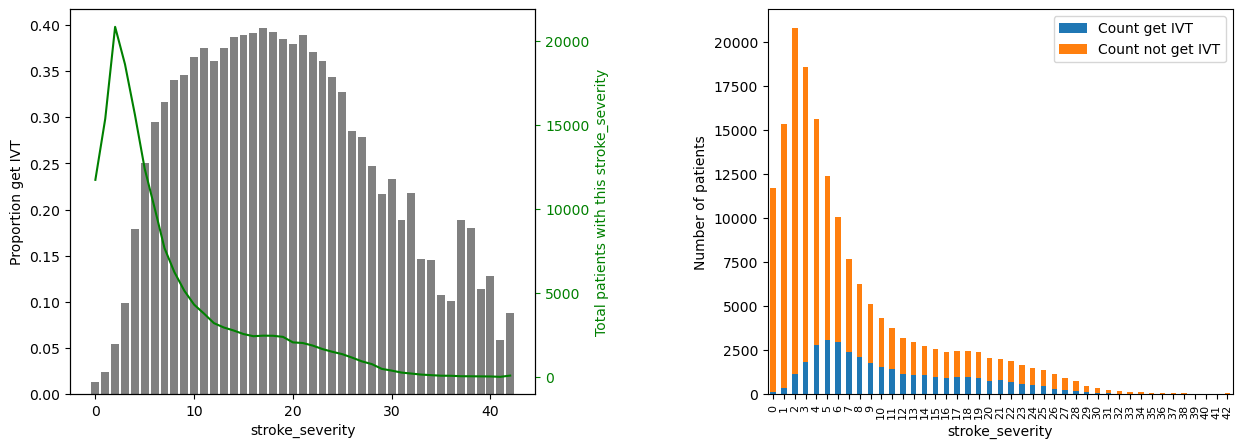

()

In [159]:
create_plots_proportion_get_thrombolysis(df_stroke_severity_results, feature_name)